In [66]:
import os
import json

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from tqdm.auto import tqdm

from PIL import Image

import matplotlib.pyplot as plt

import numpy as np
from typing import List, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
COLORS = np.array(
    [
        [0, 0, 0],  # unlabeled    =   0,
        [70, 70, 70],  # building     =   1,
        [190, 153, 153],  # fence        =   2,
        [250, 170, 160],  # other        =   3,
        [220, 20, 60],  # pedestrian   =   4,
        [153, 153, 153],  # pole         =   5,
        [157, 234, 50],  # road line    =   6,
        [128, 64, 128],  # road         =   7,
        [244, 35, 232],  # sidewalk     =   8,
        [107, 142, 35],  # vegetation   =   9,
        [0, 0, 142],  # car          =  10,
        [102, 102, 156],  # wall         =  11,
        [220, 220, 0],  # traffic sign =  12,
        [60, 250, 240],  # anomaly      =  13,
    ]
)


def color(annotated_image: np.ndarray, colors: np.ndarray = COLORS) -> Image.Image:
    print(annotated_image.shape)
    img_new = np.zeros((*annotated_image.shape, 3), dtype=np.uint8)

    for index, color in enumerate(colors):
        img_new[annotated_image == index + 1] = color

    return Image.fromarray(img_new, "RGB")

## Data Preparation


In [68]:
class StreetHazardDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, image_transform=None, target_transform=None
    ):
        # Leggi il file JSON
        with open(annotations_file, "r") as f:
            self.data = json.load(f)

        self.img_dir = img_dir  # Directory base delle immagini
        self.image_transform = image_transform
        self.target_transform = target_transform

    def __len__(self):
        # Numero di elementi nel dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Carica un campione (immagine e annotazione)
        sample = self.data[idx]
        img_path = os.path.join(self.img_dir, sample["fpath_img"])
        seg_path = os.path.join(self.img_dir, sample["fpath_segm"])

        # Carica l'immagine
        image = Image.open(img_path).convert("RGB")
        # Carica la segmentazione (opzionale)
        segmentation = Image.open(seg_path)

        # Applica trasformazioni, se specificate
        if self.image_transform:
            image = self.image_transform(image)

        if self.target_transform:
            segmentation = self.target_transform(segmentation)
            segmentation = torch.as_tensor(np.array(segmentation))

        # Restituisci immagine e annotazione
        return image, segmentation

In [69]:
# Percorsi dei file
annotations_file = "./data/train/train.odgt"
img_dir = "./data/train"

# Trasformazioni
image_transform = transforms.Compose(
    [
        transforms.Resize((14 * 20, 14 * 20), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((14 * 20, 14 * 20), interpolation=InterpolationMode.NEAREST),
        # transforms.ToTensor(),
    ]
)

# Crea il dataset
dataset = StreetHazardDataset(
    annotations_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
)
dl = DataLoader(dataset, batch_size=2, shuffle=True)

## Model definition


In [79]:
class DINOv2_SemanticSegmentation(nn.Module):
    def __init__(self, num_classes: int, image_size: Tuple[int, int]):
        super().__init__()
        self.num_classes = num_classes

        self.feature_extractor = torch.hub.load(
            "facebookresearch/dinov2", "dinov2_vits14"
        )

        self.head = SegmentationHead(num_classes, d_model=384, image_size=image_size)

        self.fine_grained_features_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

    def forward(self, x):
        y = self.feature_extractor(x, is_training=True)
        backbone_features = y["x_norm_patchtokens"]

        B, HW, d_model = backbone_features.shape
        backbone_features = backbone_features.view(
            (B, int(np.sqrt(HW)), int(np.sqrt(HW)), d_model)
        )
        backbone_features = torch.permute(backbone_features, (0, 3, 1, 2))

        fine_grained_features = self.fine_grained_features_extractor(x)

        # features = torch.cat((features, fine_grained_features), dim=1)

        return self.head(backbone_features, fine_grained_features)


class SegmentationHead(nn.Module):
    def __init__(self, num_classes: int, d_model: int, image_size: Tuple[int, int]):
        super().__init__()
        self.num_classes = num_classes

        self.l1 = nn.Linear(d_model, 512)
        self.up = nn.Upsample(image_size)
        if num_classes is not None:
            self.out = nn.Conv2d(
                512 + 128,
                num_classes,
                kernel_size=1,
                stride=1,
                padding="same",
                padding_mode="reflect",
            )
        else:
            self.out = nn.Conv2d(
                512 + 128,
                512 + 128,
                kernel_size=1,
                stride=1,
                padding="same",
                padding_mode="reflect",
            )

        # self.out = nn.Sequential(
        #     nn.Conv2d(512, 128, kernel_size=3, stride=1, padding="same"),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Conv2d(128, 64, kernel_size=3, stride=1, padding="same"),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding="same"),
        # )

    def forward(self, backbone_features, fine_grained_features):
        B, d_model, H, W = backbone_features.shape
        backbone_features = torch.permute(backbone_features, (0, 3, 2, 1))
        # (B, H, W, d_model)

        backbone_features = self.l1(backbone_features)
        # (B, H, W, 512)

        backbone_features = torch.permute(backbone_features, (0, 3, 2, 1))
        # (B, 512, H, W)

        backbone_features = self.up(backbone_features)
        # (B, 512, image_size, image_size)

        # Concatenate fine-grained features
        features = torch.cat((backbone_features, fine_grained_features), dim=1)
        # (B, 512 + 128, image_size, image_size)

        backbone_features = self.out(features)
        # (B, num_classes, image_size, image_size)
        return backbone_features

In [76]:
model = DINOv2_SemanticSegmentation(num_classes=13, image_size=(14 * 20, 14 * 20)).to(
    device
)
for param in model.feature_extractor.parameters():
    param.requires_grad = False

Using cache found in C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


## Simple SemSeg Test


In [117]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)


criterion = nn.CrossEntropyLoss()


epochs = 10



for epoch in range(epochs):

    for images, segmentations in tqdm(dl):

        images = images.to(device)

        segmentations = segmentations.to(device)


        out = model(images)

        loss = criterion(out, segmentations.long() - 1)


        optimizer.zero_grad()


        loss.backward()

        optimizer.step()


        print(f"Epoch {epoch}/{epochs} - {loss.item()}")

  0%|          | 0/2563 [00:00<?, ?it/s]

Epoch 0/10 - 1.034580945968628
Epoch 0/10 - 0.921288788318634
Epoch 0/10 - 1.1165852546691895


KeyboardInterrupt: 

torch.Size([280, 280])
torch.Size([280, 280])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [7, 7, 7,  ..., 0, 0, 0],
        [7, 7, 7,  ..., 0, 0, 0],
        [7, 7, 7,  ..., 0, 0, 0]])
tensor([[2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1],
        ...,
        [9, 9, 9,  ..., 8, 8, 8],
        [9, 9, 9,  ..., 8, 8, 8],
        [9, 9, 9,  ..., 8, 8, 8]], dtype=torch.uint8)


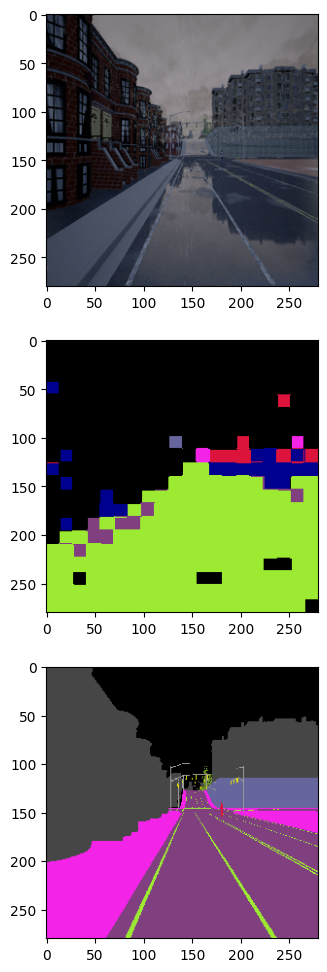

In [ ]:
# Test the trained model
for images, segmentations in dl:
    images = images.to(device)
    segmentations = segmentations.to(device)

    out = model(images)
    # Plot 3 images in the same plot (RGB, predicted, ground truth)
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))
    ax[0].imshow(images[0].permute(1, 2, 0).cpu())
    ax[1].imshow(color(out[0].argmax(dim=0).cpu()))
    ax[2].imshow(color(segmentations[0].cpu()))

    print(out[0].argmax(dim=0).cpu())
    print(segmentations[0].cpu())
    break

## Metric Learning


In [47]:
def batch_nt_bxent_loss(x, pos_indices, temperature):
    B = x.size(0)

    assert len(x.size()) == 3

    assert x.size(0) == len(pos_indices)

    loss = None
    for i in range(B):
        if loss is None:
            loss = nt_bxent_loss(x[i], pos_indices[i], temperature)
        else:
            loss += nt_bxent_loss(x[i], pos_indices[i], temperature)

    return loss


# NT-Xent Loss
def nt_bxent_loss(x, pos_indices, temperature):
    assert len(x.size()) == 2
    # print("x[i]", x)
    # print("x[i].shape", x.shape)
    # print(pos_indices)

    # Add indexes of the principal diagonal elements to pos_indices
    pos_indices = torch.cat(
        [
            pos_indices,
            torch.arange(x.size(0)).reshape(x.size(0), 1).expand(-1, 2),
        ],
        dim=0,
    )

    # Ground truth labels
    target = torch.zeros(x.size(0), x.size(0))
    target[pos_indices[:, 0], pos_indices[:, 1]] = 1.0
    target[pos_indices[:, 1], pos_indices[:, 0]] = 1.0
    # print("target", target)

    # Cosine similarity
    xcs = F.cosine_similarity(x[None, :, :], x[:, None, :], dim=-1)
    # Set logit of diagonal element to "inf" signifying complete
    # correlation. sigmoid(inf) = 1.0 so this will work out nicely
    # when computing the Binary cross-entropy Loss.
    xcs[torch.eye(x.size(0)).bool()] = float("inf")

    # Standard binary cross-entropy loss. We use binary_cross_entropy() here and not
    # binary_cross_entropy_with_logits() because of
    # https://github.com/pytorch/pytorch/issues/102894
    # The method *_with_logits() uses the log-sum-exp-trick, which causes inf and -inf values
    # to result in a NaN result.
    loss = F.binary_cross_entropy(
        (xcs / temperature).sigmoid(), target, reduction="none"
    )

    target_pos = target.bool()
    target_neg = ~target_pos

    loss_pos = torch.zeros(x.size(0), x.size(0)).masked_scatter(
        target_pos, loss[target_pos]
    )
    loss_neg = torch.zeros(x.size(0), x.size(0)).masked_scatter(
        target_neg, loss[target_neg]
    )
    loss_pos = loss_pos.sum(dim=1)
    loss_neg = loss_neg.sum(dim=1)
    num_pos = target.sum(dim=1)
    num_neg = x.size(0) - num_pos

    return ((loss_pos / num_pos) + (loss_neg / num_neg)).mean()


def custom_loss(x, ground_truth, temperature, size: int = 5):
    B = ground_truth.size(0)
    ground_truth = ground_truth.view(B, -1)

    # print(ground_truth.shape)
    selected_pixels = torch.randperm(ground_truth.size(1))[:size]
    # print(selected_pixels)
    ground_truth = ground_truth[:, selected_pixels]
    # Flatten the ground truth keeping the batch size
    ground_truth = ground_truth.flatten(1)
    # print(ground_truth)
    all_pairs = torch.combinations(torch.arange(ground_truth.size(1)), 2)
    # print(all_pairs)
    # Filter the combinations that has the same label
    # print(all_pairs)
    # print(all_pairs)
    # print(ground_truth[:, all_pairs[:, 0]] == ground_truth[:, all_pairs[:, 1]])
    pos_pairs = []
    for i in range(B):
        pos_pairs.append(
            all_pairs[
                ground_truth[i, all_pairs[:, 0]] == ground_truth[i, all_pairs[:, 1]]
            ]
        )
    # pos_pairs = all_pairs[ground_truth[:, all_pairs[:, 0]] == ground_truth[:, all_pairs[:, 1]]]
    # print(pos_pairs)
    # x = torch.randn(1, 3, 128, 128)
    B, emb_size, H, W = x.shape
    x = x.view(B, emb_size, -1)
    x = x[:, :, selected_pixels]
    # print("x.shape", x.shape)
    x = torch.permute(x, (0, 2, 1))
    temperature = 0.1
    return batch_nt_bxent_loss(x, pos_pairs, temperature)


ground_truth = torch.randint(0, 10, (1, 1, 128, 128))
x = torch.randn(1, 3, 128, 128)
loss = custom_loss(x, ground_truth, 0.1)
print(loss.item())

4.2122321128845215


In [80]:
model = DINOv2_SemanticSegmentation(num_classes=None, image_size=(14 * 20, 14 * 20)).to(
    device
)
for param in model.feature_extractor.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)
epochs = 10
# Use the custom loss function in the training loop
for epoch in range(epochs):
    for images, segmentations in tqdm(dl):
        images = images.to(device)
        segmentations = segmentations.to(device)

        out = model(images)
        loss = custom_loss(out, segmentations, 0.1, size=100)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} - {loss.item()}")

Using cache found in C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main


  0%|          | 0/2563 [00:00<?, ?it/s]

Epoch 0/10 - 4.279596328735352
Epoch 0/10 - 2.4722485542297363


KeyboardInterrupt: 

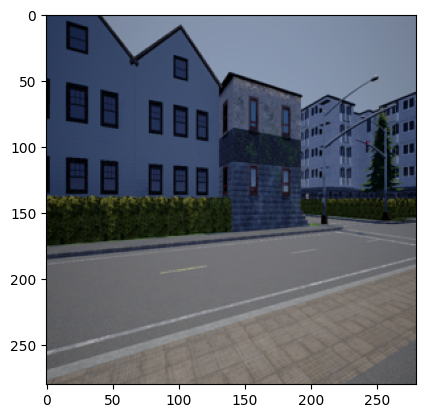

torch.Size([78400, 640])
(280, 280, 2)
tensor([167,   6,  19, 138,  22, 144, 233,  37,  28,  69, 225,  60, 195, 174,
        269, 133,   5,  57, 128, 246, 113,  45,  51, 160, 272, 111,  10, 217,
        276,  30, 120, 148, 121,  91, 213, 142, 266,  99, 202, 215, 245, 165,
        190, 198,  44, 234, 242,  55, 207,  75,  50, 100, 226, 125, 155,  79,
        205, 107, 274, 204,  89, 216,  34, 254, 147,  32, 230,  18,  82,  80,
        263,  38,  17,  73,  14, 123, 145,  46, 227, 127,  12,  16,  58, 235,
        152, 115,  78, 156, 172, 221, 244, 257, 278, 247,  40, 189,  49, 277,
        267, 220])
tensor([ 78, 276, 160, 213,  32, 226, 115, 186, 152, 140,  24, 258,  50,  46,
        123,  69, 198, 151, 251, 252, 158,  72,  87, 232, 201, 203,  19, 196,
        259, 244, 124,  60,  52, 107, 153, 182, 218, 230, 238,  51,  81,  62,
          8, 195,  42, 273, 189, 106, 250, 208, 105,  26, 172, 277,  66, 204,
        167,  61, 212, 155, 211,  90,  94,  74,  63, 215, 243, 262, 125,  77,
      

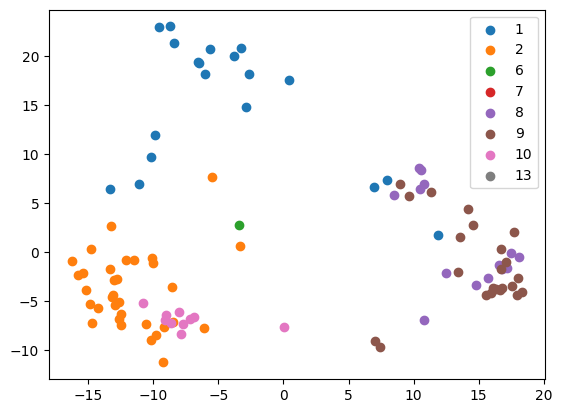

In [109]:
from sklearn.decomposition import PCA

for images, segmentations in dl:
    image = images[0].to(device)
    segmentation = segmentations[0].to(device)
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.show()

    out = model(image[None, ...])
    # Apply PCA on the channel dimension of the output embeddings
    out = out[0]
    pca = PCA(n_components=2)
    C, H, W = out.shape
    out = torch.permute(out, (1, 2, 0))
    out = out.view(-1, out.size(-1))
    print(out.shape)
    pca_out = pca.fit_transform(out.cpu().detach().numpy())
    pca_out = pca_out.reshape(H, W, 2)
    print(pca_out.shape)
    # Pick 1000 random pixels
    N = 100
    selected_pixels_x = torch.randperm(H)[:N]
    selected_pixels_y = torch.randperm(W)[:N]
    print(selected_pixels_x)
    print(selected_pixels_y)
    different_segmentation_values = torch.unique(segmentation)
    for i in range(len(different_segmentation_values)):
        plt.scatter(
            x=pca_out[selected_pixels_x, selected_pixels_y][
                segmentation[selected_pixels_x, selected_pixels_y]
                == different_segmentation_values[i].item(),
                0,
            ],
            y=pca_out[selected_pixels_x, selected_pixels_y][
                segmentation[selected_pixels_x, selected_pixels_y]
                == different_segmentation_values[i].item(),
                1,
            ],
            label=different_segmentation_values[i].item(),
        )
    """ plt.scatter(x=pca_out[selected_pixels_x, selected_pixels_y][:, 0],
                y=pca_out[selected_pixels_x, selected_pixels_y][:, 1]) """
    # label=segmentation[selected_pixels_x[i], selected_pixels_y[i]].item())
    # print(segmentation[selected_pixels_x[i], selected_pixels_y[i]].item())
    plt.legend()
    plt.show()
    break